This is a notebook to process the DREAGON data set using cACGMM algorithem for BSS:

In [146]:
import io
import functools
import numpy as np
import soundfile as sf
import matplotlib
import matplotlib.pylab as plt
from IPython.display import display, Audio
from einops import rearrange
from nara_wpe.utils import stft, istft

import the algorithems used for the (not DL method) of BSS:

In [147]:
from pb_bss.distribution import CACGMMTrainer, CBMMTrainer, CWMMTrainer
from pb_bss.permutation_alignment import DHTVPermutationAlignment, OraclePermutationAlignment
from pb_bss.evaluation import InputMetrics, OutputMetrics

## Reading the audio files:
reading audio files from the DREGON dataset of drone recordings:

In [148]:
# THIS IS the original read method used by the BSS (blinf source seperation) study
# do we need a spacific sample rate?
# sample_rate = 8000

def soundfile_read(path):
    data, data_sample_rate = sf.read(path)
    
    # shuld I have this on?
    # assert sample_rate == data_sample_rate, (sample_rate, data_sample_rate)
    
    print(f'Read: {url}.\nSample rate: {data_sample_rate}')
    return np.ascontiguousarray(data.T)



In [149]:
free_flight_wav_file = 'C:/Users/shaig/Documents/CS_Technion/2019_b/Deep Learning Project/DL_project_2019/DREGON_dataset/DREGON_free-flight_nosource_room1/DREGON_free-flight_nosource_room1.wav'

# using SoundFile() instead of read(), because files are larger, might need to cut them for later use
with sf.SoundFile(free_flight_wav_file, mode='r') as f:
    print(f'sample rate: {f.samplerate}, channels: {f.channels} ')
    # the file is 98MB, we don't want to read it all, else we will use soundfile.read()/ sf.read()
    f.seek(10000)
    data = f.read(50000)
    
    # check if that does anithing - it does not
    # data2 = np.ascontiguousarray(data.T)
    # print(type(data), data.shape, type(data2), data2.shape)
    # print(data.T - data2)

# print(data)
print(f'dtype: {data.dtype}')

sample rate: 44100, channels: 8 
dtype: float64


## Some functions for plotting

In [150]:
def plot_mask(mask, *, ax=None):
    if ax is None:
        ax = plt.gca()
    image = ax.imshow(
        mask,
        interpolation='nearest',
        vmin=0,
        vmax=1,
        origin='lower'
    )
    cbar = plt.colorbar(image, ax=ax)
    return ax

def plot_stft(stft_signal, *, ax=None):
    if ax is None:
        ax = plt.gca()
        
    stft_signal = np.abs(stft_signal)
        
    
    stft_signal = 10 * np.log10(
        np.maximum(stft_signal, np.max(stft_signal) / 1e6))
    # 1e6: 60 dB is sufficient
        
    image = ax.imshow(
        stft_signal,
        interpolation='nearest',
        origin='lower',
    )
    cbar = plt.colorbar(image, ax=ax)
    cbar.set_label('Energy / dB')
    return ax

## Transforming it into spectrograms 

f:  257 <class 'numpy.ndarray'>
t:  783 <class 'numpy.ndarray'>
data_stft:  (8, 257, 783)


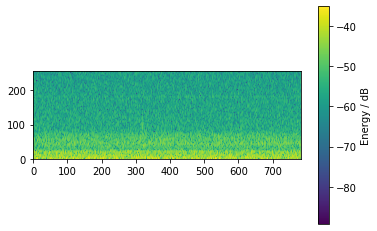

In [151]:
# instead of using the experiment stft, use scipy's implementation
from scipy import signal
# nperseg is the number of samples used for each spectrogram, (with (nperseg/2) overlap between them)
# nfft - is the number of frequancy bins used in the dft method, the number of bins will be nfft/2 + 1
# we want the channel to be the first dimention, so use .T method

fft_size = 512
time_window = 128

f, t, data_stft = signal.stft(data.T, nperseg=128, nfft=512)
print("f: ", len(f), type(f))
print("t: ", len(t), type(t))
print("data_stft: ", data_stft.shape)

plot_stft(data_stft[0])

## Using the model:

1. Instantiate a Trailer

2. Call fit on the data

3. Give a prediction

In [152]:
# for the model to work properly, we need the dimentions to be orderd in the fallowing way:
# frequancies, time, and channels, so lets transform our data:
data_stft_mm = rearrange(data_stft, 'channels freq time -> freq time channels')
# 1 -
trainer = CACGMMTrainer()

# 2 - 
model = trainer.fit(
    data_stft_mm,
    num_classes=2,
    iterations=40,
)
# print("momdel: ", model)

def string_function(a):
    if a.size < 50:
        return str(a)
    else:
        return f'array(shape={a.shape}, dtype={a.dtype})'
np.set_string_function(string_function)

# 3 - 
affiliation = model.predict(data_stft_mm)


In [153]:
print(type(affiliation), affiliation.shape)
affiliation = rearrange(affiliation, 'freq source time -> source freq time')
print(type(affiliation), affiliation.shape)


<class 'numpy.ndarray'> (257, 2, 783)
<class 'numpy.ndarray'> (2, 257, 783)


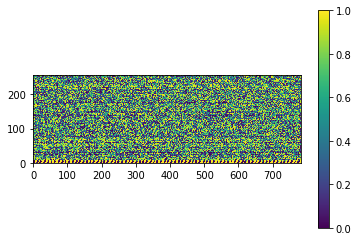

In [154]:
plot_mask(affiliation[0, :, :])

## Permutation alignment - 

In [155]:
pa = DHTVPermutationAlignment.from_stft_size(fft_size)

affiiliation_pa:  <class 'numpy.ndarray'> (2, 257, 783)


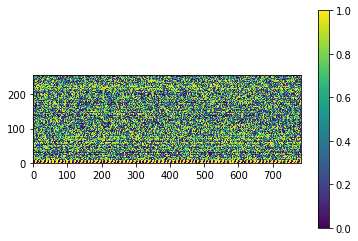

In [156]:
mapping = pa.calculate_mapping(
    affiliation,
)
affiliation_pa = pa.apply_mapping(
    affiliation,
    mapping,
)
# affiliation_pa = pa(affiliation)

print('affiiliation_pa: ', type(affiliation_pa), affiliation_pa.shape)
# Shaigue added
plot_mask(affiliation_pa[0, :, :])

## Does not seem to work

lets try 2 other things:
1. testing it on an artificial mix I made on `generate_sound_samples.ipynb`
2. testing it on recorded drone sound and speech sound

### Steps (again):
1. Read
2. STFT
3. Model
4. PA
5. Global PA

In [157]:
# 1 - read
synthesized_mix, _ = sf.read('sound_samples/rotors_and_4kHz_sin_wave.wav')
# recorded_mix, _ = sf.read('sound_samples/rotors_and_speech.wav')
# synthesized_mix, _ = sf.read('sound_samples/rotors_and_speech.wav')
cut_sample = 44100
synthesized_mix = synthesized_mix.T
# recorded_mix = recorded_mix.T
synthesized_mix = synthesized_mix[:, :cut_sample]
# recorded_mix = recorded_mix[:, :cut_sample]
print(synthesized_mix.shape)
# print(recorded_mix.shape)

(8, 44100)


recorded shape: (8, 257, 337) 


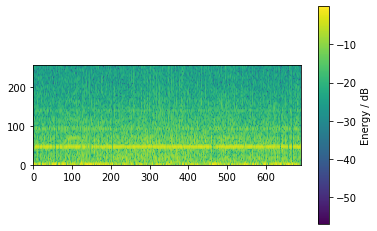

In [158]:
# 2 - stft
_, _, synthesized_stft = signal.stft(synthesized_mix, nperseg=time_window, nfft=fft_size)
# _, _, recorded_stft = signal.stft(recorded_mix, nperseg=time_window, nfft=fft_size)
print(f'recorded shape: {recorded_stft.shape} ')#synthesized shape: {synthesized_stft.shape}')
# plt.subplot(1, 2, 1)
plot_stft(synthesized_stft[0, :, :])
# plt.subplot(1, 2, 2)
# plot_stft(recorded_stft[0, :, :])

In [159]:
trainer = CACGMMTrainer()
# trainer = CWMMTrainer()
# trainer = CBMMTrainer()

mask shape: (2, 257, 691)


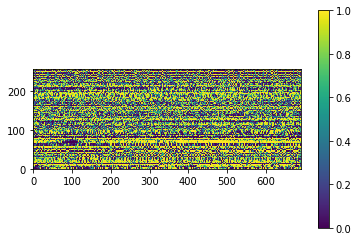

In [160]:
# 3 - model
# recorded_stft = rearrange(data_stft, 'channels freq time -> freq time channels')
synthesized_stft_mm = rearrange(synthesized_stft, 'channels freq time -> freq time channels')

model = trainer.fit(
    synthesized_stft_mm,
    num_classes=2,
    iterations=100,
)
 
synthesized_affiliation = model.predict(synthesized_stft_mm)
synthesized_affiliation = rearrange(synthesized_affiliation, 'freq source time -> source freq time')
print(f'mask shape: {synthesized_affiliation.shape}')
plot_mask(synthesized_affiliation[0, :, :])

shape: (2, 257, 691)


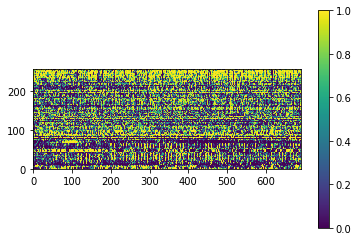

In [161]:
# 4 - PA
pa = DHTVPermutationAlignment.from_stft_size(fft_size)
synthesized_affiliation_pa = pa(synthesized_affiliation)
print(f'shape: {synthesized_affiliation_pa.shape}')
plot_mask(synthesized_affiliation_pa[0, :, :])

In [162]:
# if you have the mixed sources, using global PA to determine, maps between mask index to source 
# 5 - Global PA
# global_pa_est = rearrange(synthesized_affiliation_pa, 'k f (t d) -> k d t f', d=1)
# synthesized_stft_x = rearrange(synthesized_stft, 'd (f k) t -> k d t f', k=1)
# global_pa_est = global_pa_est * synthesized_stft_x
# global_pa_est = rearrange(global_pa_est, 'k d t f -> k (d t f)')
# global_pa_est

In [163]:
source1_stft = np.array([synthesized_affiliation_pa[0] * synthesized_stft[channel] for channel in range(8)])
source2_stft = np.array([synthesized_affiliation_pa[1] * synthesized_stft[channel] for channel in range(8)])
# source2_stft
_, source1_est = signal.istft(source1_stft, nperseg=time_window, nfft=fft_size)
source1_est
Audio(data=source1_est, rate=22050)

In [164]:
_, source2_est = signal.istft(source2_stft, nperseg=time_window, nfft=fft_size)
Audio(data=source2_est, rate=22050)

## Ok, so not so seccessful yet
### Lets try the data used in the paper, and see if we use the recources corectlly

we will create a function taking the process of reading, 

In [170]:
def print_arr(message, arr):
    print(f'{message}, shape: {arr.shape}, dtype: {arr.dtype}')

In [177]:
def seperate_sources(file, num_classes, num_channels=8, sample_rate=44100, 
                     num_samples=44100, nperseg=128, nfft=512, iterations=100):
    """
    file - the path to the audio file
    num_classes - the number of classes to seperate
    sample_rate - the sample rate of the file
    num_samples - the number of frames to run the algorithem on
    nperseg - the time window size of the stft
    nfft - the number of frequancy bins in the stft
    iterations - the number of iterations to do
    @returns - a list of the seperated sources
    """
    # read from the file
    audio_data , actual_sample_rate = sf.read(file)
    assert actual_sample_rate == sample_rate
    
    ## debug
    print_arr('read arr', audio_data)
    ##
    
    audio_data = audio_data[:num_samples]
    audio_data = audio_data.T
    
    ## debug
    print_arr('after transform', audio_data)
    ##
    
    # make stft
    f, t, stft_data = signal.stft(audio_data, nperseg=nperseg, nfft=nfft)
    
    ## debug
    print_arr('stft', stft_data)
    ##
    
    # trainer + training + prediction:
    trainer = CACGMMTrainer()
    
    stft_data_mm = rearrange(stft_data, 'channel freq time -> freq time channel')
    
    ## debug
    print_arr('stft_mm', stft_data_mm)
    ##
    
    model = trainer.fit(
        stft_data_mm,
        num_classes=num_classes,
        iterations=iterations,
    )
    
    affiliation = model.predict(stft_data_mm)
    
    ## debug
    print_arr('affiliation', affiliation)
    ##
    
    affiliation = rearrange(affiliation, 'freq source time -> source freq time')
    
    ## debug
    print_arr('affiliation rearrange', affiliation)
    ##
    
    # permutation alignment
    pa = DHTVPermutationAlignment.from_stft_size(nfft)
    affiliation_pa = pa(affiliation)
    
    ## debug
    print_arr('affiliation_pa', affiliation_pa)
    ##
    
    ## just for testing
    plot_mask(affiliation_pa[0])
    ##
    
    # use the mask to estimate the source signal
    # should it be a different mask for each channel???
    seperated_sources_stft = []
    for i in range(num_classes):
        source = [affiliation_pa[i] * stft_data[c] for c in range(num_channels)] 
        seperated_sources_stft.append(source)
    seperated_sources_stft = np.array(seperated_sources_stft)
    
    ## debug
    print_arr('seperated stft', seperated_sources_stft)
    ##
    
    # restore the estimated seperated sounds
    t, seperated_sources_audio = signal.istft(seperated_sources_stft, 
                                              nperseg=nperseg, nfft=nfft)
    
    ## debug
    print_arr('seperated sound', seperated_sources_audio)
    ##
    
    # return the seperated signal
    return seperated_sources_audio
    

read arr, shape: (38520, 6), dtype: float64
after transform, shape: (6, 38520), dtype: float64
stft, shape: (6, 257, 603), dtype: complex128
stft_mm, shape: (257, 603, 6), dtype: complex128
affiliation, shape: (257, 3, 603), dtype: float64
affiliation rearrange, shape: (3, 257, 603), dtype: float64
affiliation_pa, shape: (3, 257, 603), dtype: float64
seperated stft, shape: (3, 6, 257, 603), dtype: complex128
seperated sound, shape: (3, 6, 38528), dtype: float64


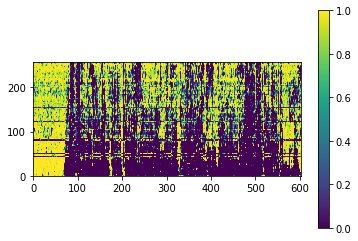

In [179]:
kwargs = { 
    'file': 'sound_samples/original.wav',
    'num_classes': 3,
    'num_channels': 6,
    'sample_rate': 8000,
    'num_samples': 38520,
    'nperseg': 128,
    'nfft': 512,
    'iterations': 40,
}

sources = seperate_sources(**kwargs)

In [181]:
Audio(sources[0], rate=kwargs['sample_rate'])

In [183]:
Audio(sources[1], rate=kwargs['sample_rate'])

In [184]:
Audio(sources[2], rate=kwargs['sample_rate'])